In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
# top 7 MarketCap in S&P500(SPX)
tickers = ['^GSPC', 'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'META']

df_close = pd.DataFrame()

for ticker in tickers:
    data = pd.read_csv(f'data/{ticker}.csv', index_col="Date", parse_dates=True)
    
    close_prices = data['Close'].rename(ticker + "_close")
    
    df_close = pd.concat([df_close, close_prices], axis=1)

df_close

,^GSPC_close,AAPL_close,MSFT_close,AMZN_close,NVDA_close,GOOGL_close,TSLA_close,META_close
1927-12-30 00:00:00,17.660000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-03 00:00:00,17.760000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-04 00:00:00,17.719999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-05 00:00:00,17.549999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-06 00:00:00,17.660000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-04-08 00:00:00,5202.390137,168.449997,424.589996,185.190002,871.330017,154.850006,172.979996,519.250000
2024-04-09 00:00:00,5209.910156,169.669998,426.279999,185.669998,853.539978,156.600006,176.880005,516.900024
2024-04-10 00:00:00,5160.640137,167.779999,423.260010,185.949997,870.390015,156.139999,171.759995,519.830017
2024-04-11 00:00:00,5199.060059,175.039993,427.929993,189.050003,906.159973,159.410004,174.600006,523.159973


In [3]:
df_close.dropna(inplace=True)
df_close

,^GSPC_close,AAPL_close,MSFT_close,AMZN_close,NVDA_close,GOOGL_close,TSLA_close,META_close
2012-05-18 00:00:00,1295.219971,18.942142,29.270000,10.692500,3.020000,15.025025,1.837333,38.230000
2012-05-21 00:00:00,1315.989990,20.045713,29.750000,10.905500,3.072500,15.368118,1.918000,34.029999
2012-05-22 00:00:00,1316.630005,19.891787,29.760000,10.766500,3.035000,15.035035,2.053333,31.000000
2012-05-23 00:00:00,1318.859985,20.377144,29.110001,10.864000,3.110000,15.251752,2.068000,32.000000
2012-05-24 00:00:00,1320.680054,20.190001,29.070000,10.762000,3.027500,15.106607,2.018667,33.029999
...,...,...,...,...,...,...,...,...
2024-04-08 00:00:00,5202.390137,168.449997,424.589996,185.190002,871.330017,154.850006,172.979996,519.250000
2024-04-09 00:00:00,5209.910156,169.669998,426.279999,185.669998,853.539978,156.600006,176.880005,516.900024
2024-04-10 00:00:00,5160.640137,167.779999,423.260010,185.949997,870.390015,156.139999,171.759995,519.830017
2024-04-11 00:00:00,5199.060059,175.039993,427.929993,189.050003,906.159973,159.410004,174.600006,523.159973


In [4]:
df_close.isna().sum()

^GSPC_close    0
AAPL_close     0
MSFT_close     0
AMZN_close     0
NVDA_close     0
GOOGL_close    0
TSLA_close     0
META_close     0
dtype: int64

<Axes: >

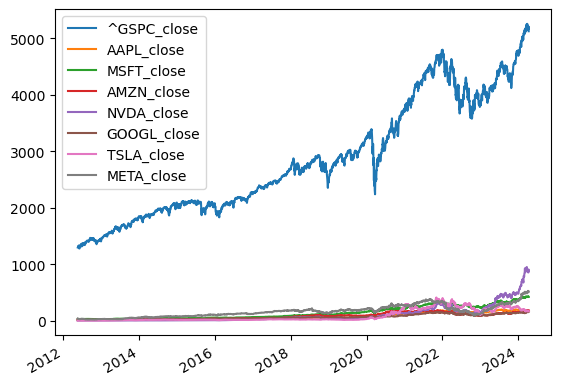

In [5]:
df_close.plot()

In [6]:
df_log_return = pd.DataFrame()

for name in df_close.columns:
  col_name = name[:-6] + "_log_return"
  df_log_return[col_name] = np.log(df_close[name]).diff()
  
df_log_return

,^GSPC_log_return,AAPL_log_return,MSFT_log_return,AMZN_log_return,NVDA_log_return,GOOGL_log_return,TSLA_log_return,META_log_return
2012-05-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-21 00:00:00,0.015909,0.056626,0.016266,0.019725,0.017235,0.022578,0.042968,-0.116378
2012-05-22 00:00:00,0.000486,-0.007708,0.000336,-0.012828,-0.012280,-0.021912,0.068181,-0.093255
2012-05-23 00:00:00,0.001692,0.024107,-0.022083,0.009015,0.024411,0.014311,0.007118,0.031749
2012-05-24 00:00:00,0.001379,-0.009226,-0.001375,-0.009433,-0.026886,-0.009562,-0.024145,0.031680
...,...,...,...,...,...,...,...,...
2024-04-08 00:00:00,-0.000375,-0.006686,-0.002188,0.000648,-0.009992,0.015292,0.047837,-0.015460
2024-04-09 00:00:00,0.001444,0.007216,0.003972,0.002589,-0.020628,0.011238,0.022296,-0.004536
2024-04-10 00:00:00,-0.009502,-0.011202,-0.007110,0.001507,0.019549,-0.002942,-0.029373,0.005652
2024-04-11 00:00:00,0.007417,0.042361,0.010973,0.016534,0.040274,0.020726,0.016400,0.006385


<Axes: >

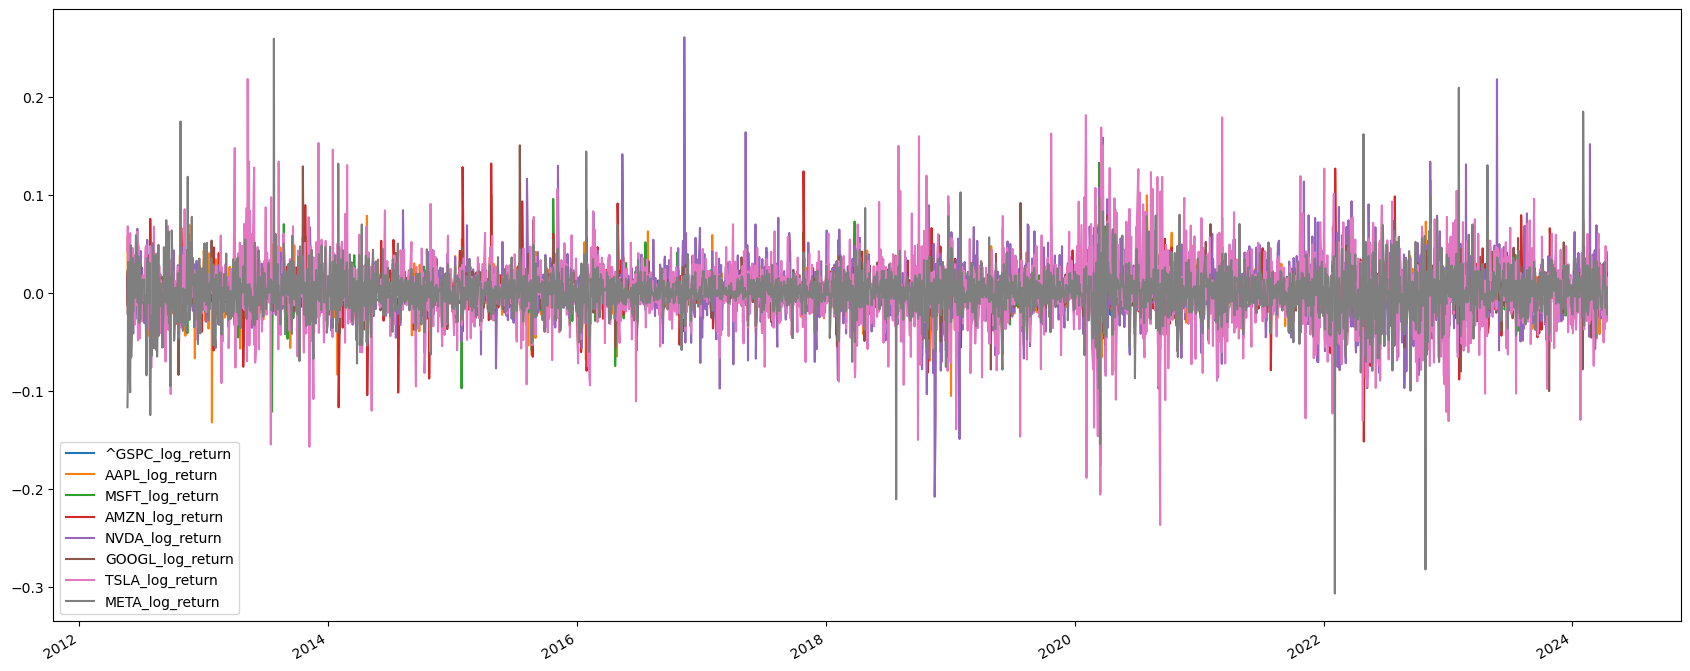

In [7]:
df_log_return.plot(figsize=(21,9))

In [8]:
df_log_return['^GSPC_log_return'] = df_log_return['^GSPC_log_return'].shift(-1)
df_log_return['^GSPC_log_return'].tail()

2024-04-08 00:00:00    0.001444
2024-04-09 00:00:00   -0.009502
2024-04-10 00:00:00    0.007417
2024-04-11 00:00:00   -0.014658
2024-04-12 00:00:00         NaN
Name: ^GSPC_log_return, dtype: float64

In [9]:
Ntest = 1000
df_train = df_log_return.iloc[1:-Ntest]
df_test = df_log_return.iloc[-Ntest:-1]

In [10]:
X_train = df_train.drop(columns=['^GSPC_log_return'])
X_test = df_test.drop(columns=['^GSPC_log_return'])

y_train = df_train['^GSPC_log_return']
y_test = df_test['^GSPC_log_return']

In [14]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.030016081397539196, -0.017649128416641346)

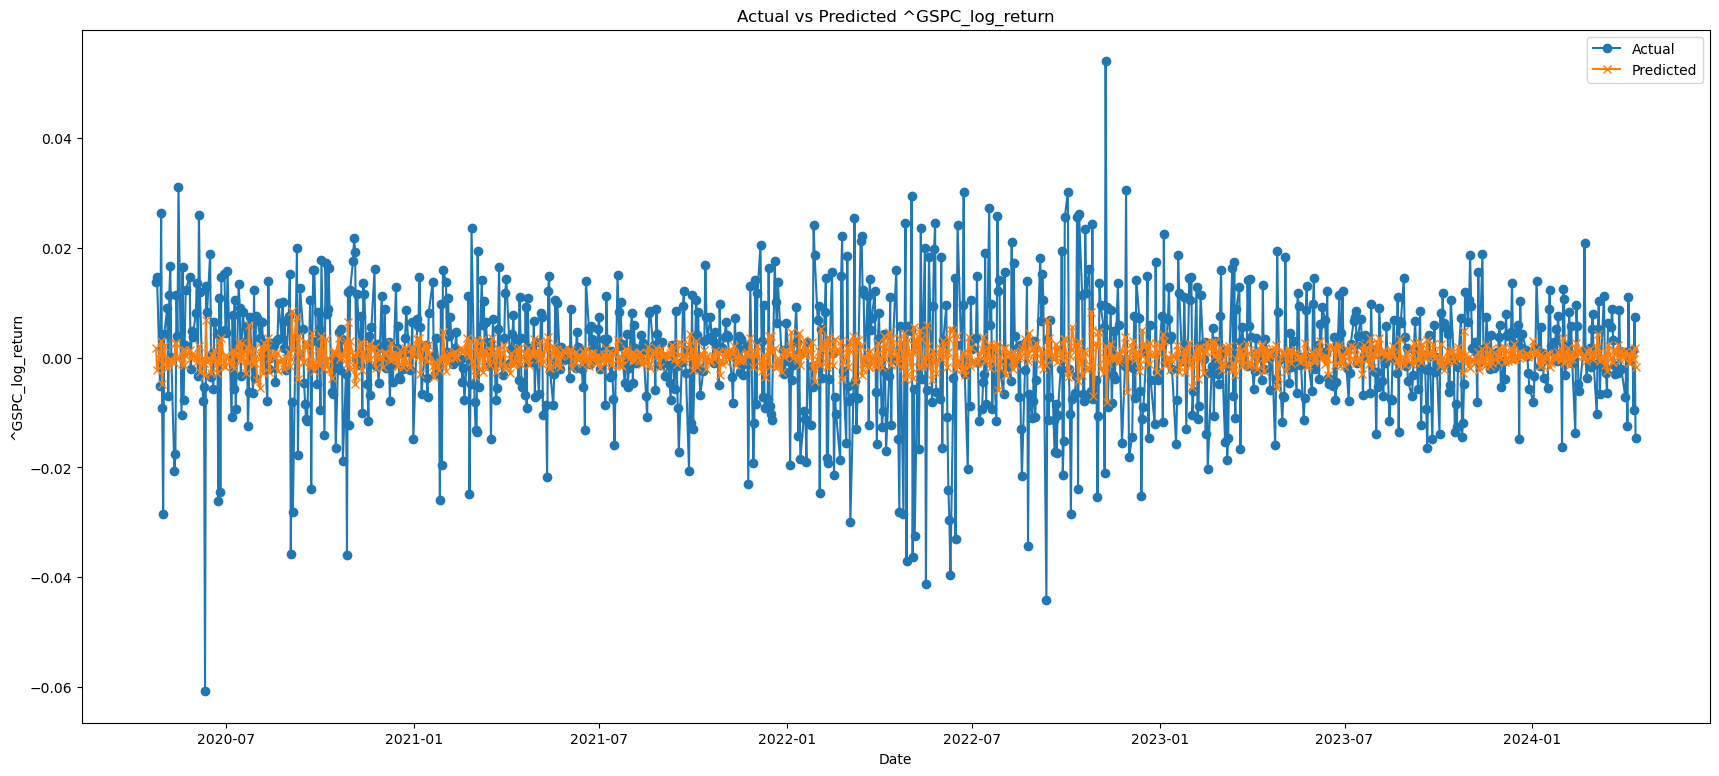

In [16]:
y_pred = model.predict(X_test)

plt.figure(figsize=(21, 9))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted', marker='x')
plt.xlabel('Date')
plt.ylabel('^GSPC_log_return')
plt.title('Actual vs Predicted ^GSPC_log_return')
plt.legend()
plt.show()

In [17]:
# Direction
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
np.mean(np.sign(y_pred_train) == np.sign(y_train)), np.mean(np.sign(y_pred_test) == np.sign(y_test))

(0.5283492222779729, 0.5285285285285285)

In [18]:
set(np.sign(y_pred_train)), set(np.sign(y_pred_test))

({-1.0, 1.0}, {-1.0, 1.0})